# A4 Convolutional Neural Networks

Brent Staab

## Instructions

In this assignment, you will finish writing this new class, named `NeuralNetwork_Convolutional` that uses the `torch.nn` module to construct neural networks with initial convolutional layers followed by fully connected layers to learn to classify images.  Your main job is to finish the `train` function, following steps shown in lecture notes.

The network will have some number, possibly zero, layers of convolutional units having the `tanh` activation function.  These are followed by one or more layers with fully connected units with `tanh` activation functions.

A tricky part of building this structure is determining the correct number of inputs to the first fully-connected layer.  This requires knowing the size of the output image generated by the last convolutional layer.  If this layer produces an output image that is $n\times n$ and it has $m$ units, then the concatenation of all image values for all units into one vector to form the input to the fully-connected layer, the resulting vector will be $m \cdot n^2$.

As an example, say our data contains images that are $d\times d$ and we have a neural network with two convolutional layers and one fully connected layer. 

Original input image: 
- $d\times d$ of $c$ channels

First convolutional layer with $u_1$ units having kernels sized $k_1\times k_1$ and strides of $s_1$
- input is $d\times d$ of $c$ channels
- output is $z_1\times z_1$ of $u_1$ channels, where $z_1 = \frac{d - k_1}{s_1} + 1$

Second convolutional layer with $u_2$ units having kernels sized $k_2\times k_2$ and strides of $s_2$
- input is $z_1\times z_1$ of $u_1$ channels
- output is $z_2\times z_2$ of $u_2$ channels, where $z_2 = \frac{z_1 - k_2}{s_2} + 1$


Third convolutional layer is fully-connected, so we must flatten into a vector the output from the previous convolutional layer. Say this layer has $u_3$ units.
- input is $u_2 \, z_2 ^ 2$
- output is $u_3$ values

## Import code needed in this notebook

In [1]:
import numpy as np
import torch
import time
import copy
import sys

import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

import pickle, gzip

## Definition of `NeuralNetwork_Convolutional`

In [2]:
class NeuralNetwork_Convolutional():
    # Initilization function (a.k.a. constructor) for object
    def __init__(self, 
                 n_channels_in_image,         # (int) number of values per pixel 
                 image_size,                  # (int) number of rows in image, same as number of columns
                 n_units_in_conv_layers,      # (list of ints) number of units in each convolutional layer
                 kernels_size_and_stride,     # (list of lists) each list is [kernel_size, kernel_stride] for each convolutional layer
                 n_units_in_fc_hidden_layers, # (list of ints) number of units in fully-connected layers
                 classes,                     # (list of ints) labels for each class
                 use_gpu=False):              # (boolean) flag indicating GPU use or not (default = no GPU)

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)
      
        # Build the net layers
        self.nnet = torch.nn.Sequential()

        # Add convolutional layers
        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:

            for (n_units, kernel) in zip(self.n_units_in_conv_layers, self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 # for text label in layer
                
            self.nnet.add_module('flatten', torch.nn.Flatten())  # prepare for fc layers

        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1

        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))
        
        # Define loss and optimizer functions
        self.loss_F = torch.nn.CrossEntropyLoss()
        
        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  # convert to labels from 0

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

        self.optimizer = torch.optim.Adam(self.nnet.parameters(), lr=self.learning_rate)
        
        # You fill in the rest of the train function, following lecture notes example.
        for epoch in range(n_epochs):
            self.optimizer.zero_grad()

            Y = self.nnet(X)

            error = self.loss_F(Y, T)
            self.error_trace.append(error)
            if epoch % 5 == 0:
                print(f'Epoch {epoch} error {error:.5f}')

            error.backward()

            self.optimizer.step()
        
        self.training_time = time.time() - start_time
        
    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  # turn off gradients and other aspects of training
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)

## Simple Example with Squares and Diamonds

Repeating the example from lecture notes.

In [3]:
def make_images(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.int)

Xtrain, Ttrain = make_images(500)
Xtest, Ttest = make_images(10)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 1, 20, 20), (1000, 1), (20, 1, 20, 20), (20, 1))

In [4]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5], # , 5],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=[1, 2],
                                   kernels_size_and_stride=[[5, 2]], #conv_kernels=[[5, 2]], # , [4, 1]],
                                   use_gpu=False)

#nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

In [5]:
nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Epoch 0 error 0.76605
Epoch 5 error 0.49396
Epoch 10 error 0.35058
Epoch 15 error 0.24259
Epoch 20 error 0.16643
Epoch 25 error 0.11843
Epoch 30 error 0.09073
Epoch 35 error 0.07337
Epoch 40 error 0.06145
Epoch 45 error 0.05263


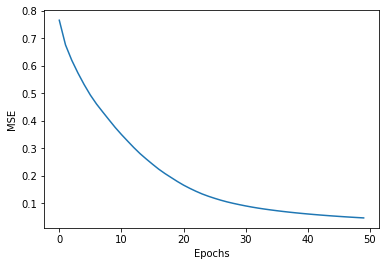

In [6]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

In [7]:
Yclasses, Y = nnet.use(Xtest)

print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.', end='')
print(f'  Training took {nnet.training_time:.3f} seconds.')

20 out of 20 test samples correctly classified.  Training took 0.451 seconds.


Let's see what the output of the convolutional layer produces, and the weight matrices of each unit that produce those output images.   Here are functions, `show_layer_output` and `show_layer_weights` that will do this for us.

In [8]:
import matplotlib.pyplot as plt

def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :], cmap='binary')
        plt.axis('off')
    return W

(-0.5, 19.5, 19.5, -0.5)

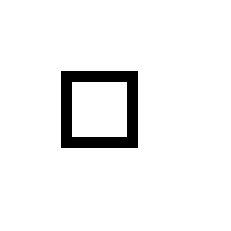

In [9]:
X_sample = Xtest[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :], cmap='binary')
plt.axis('off')

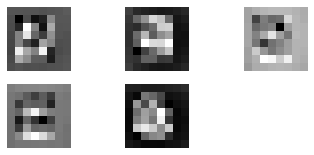

In [10]:
show_layer_output(nnet, X_sample, 0);

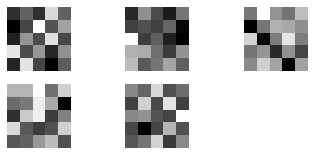

In [11]:
show_layer_weights(nnet, 0);

## MNIST Digits

Investigate the application of your code to the classification of MNIST digits, which you may download from [this site](http://deeplearning.net/tutorial/gettingstarted.html).

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [13]:
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtrain.shape, Ttrain.shape

((50000, 784), (50000,))

In [14]:
a = Xtrain[0, :].reshape(28, 28)
a.shape

(28, 28)

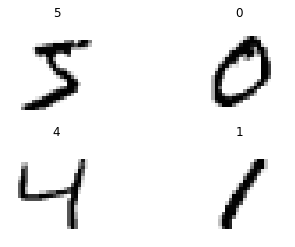

In [15]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtrain[i, :].reshape(28, 28), cmap='binary')
    plt.title(Ttrain[i])
    plt.axis('off');

**Required:** Try different numbers of layers and units, kernel sizes and strides, and learning rates and epochs to get greater than 90% test images correctly classified.  Your grade will only depend on you showing various results, not on achieving this accuracy.

In [16]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [17]:
Xtest = test_set[0]
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].reshape(-1, 1, 28, 28)
Ttest = test_set[1][testi].reshape(-1, 1)

In [18]:
torch.random.manual_seed(42)
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5, 5],
                                   kernels_size_and_stride=[[5, 3], [4, 2]],
                                   n_units_in_fc_hidden_layers=[10],
                                   classes=[0, 1, 2],
                                   use_gpu=False)

In [19]:
nnet.train(Xtrain, Ttrain, 20, learning_rate=0.01)

Epoch 0 error 1.11647
Epoch 5 error 0.69274
Epoch 10 error 0.31685
Epoch 15 error 0.15003


In [20]:
Yclasses, Y = nnet.use(Xtest)
n_correct = (Yclasses == Ttest).sum()
print(f'{n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

27 out of 30 samples, or 90.00 percent.


# Grading

Download [A4grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.zip) and extract A4grader.py from it. 

In [22]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Staab-A4.1.ipynb' and storing in notebookcode.py


IndentationError: expected an indented block (eval, line 1030)